# Model Training

### Fuzzy C Means

Data Loading

In [1]:
# Import necessary libraries
import torch
import pickle
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the processed data
df = pd.read_csv('data/model_data.csv')
df.head()

article
0  buy much red cabbage turn festive nut roast re...
1  scaly stowaway lizard make appearance chelsea ...
2  uk energy industry urge minister stick net zer...
3  article months oldfood fee fuel global seaweed...
4  article months oldus behind third global oil g...

Vectorize the data

In [3]:
# Use pretrained model BERT to transform the words
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

X_bert = get_bert_embeddings(df['article'].tolist())
X_scaled = StandardScaler().fit_transform(X_bert)

Dimension Reduction

In [8]:
# Use PCA to reduce dimension into 50
pca = TruncatedSVD(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Use UMAP to reduce the dimension into 2 for visualization purpose
reducer = UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='cosine', random_state=42)
X = reducer.fit_transform(X_pca)

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Save the vectorization
pipeline = {
    'tokenizer': tokenizer,
    'bert_model': bert_model,
    'pca': pca,
    'umap': reducer
}

with open('model/vectorization.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

Visualization before Model Training

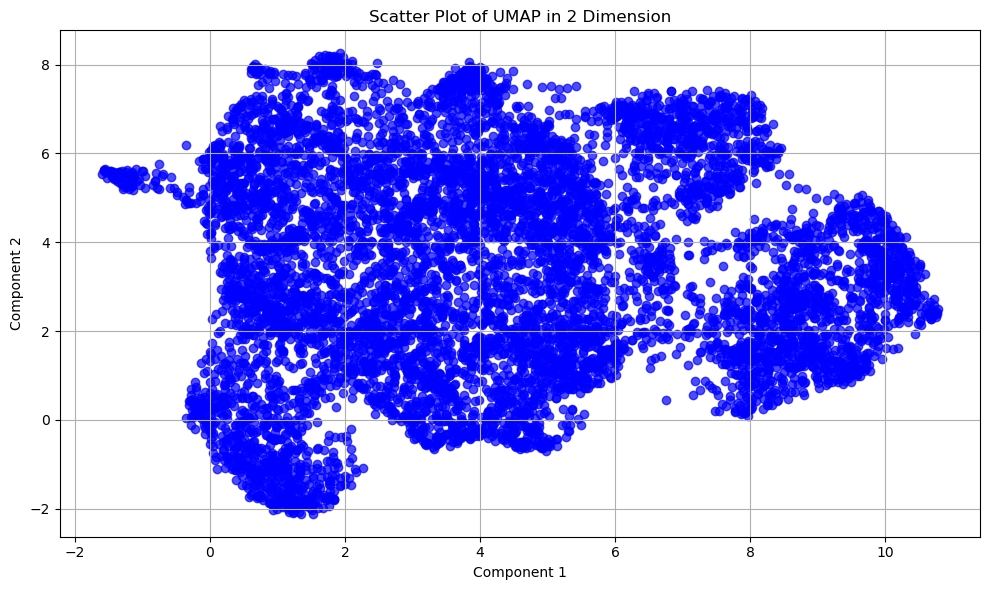

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.7)
plt.title("Scatter Plot of UMAP in 2 Dimension")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Training

In Fuzzy C Means, the algorithms is:
1. Assign and initialize number of clusters and fuzziness parameter
2. Update the membership values
3. Update the cluster centroid values
4. Keep update the membership values and cluster centers until both stop changing significantly

In [11]:
# Number of cluster to test which is optiimal
cluster_range = range(2,16) 

# Fuzziness parameter
m_values = [1.1, 1.5, 2.0, 2.5] 

# Maximum iteration
MAX_ITER = 1000

# Convergence
epsilon = 0.001

# Evaluation metrics to track
distortions = []
silhouette_scores = []
dbi_scores = []
pc_scores = []
pe_scores = []
fuzzy_sil_scores = []

In [12]:
# Function to calculate the partition coefficient
def partition_coefficient(u):
    if u.shape[0] < u.shape[1]:
        u = u.T  
    return np.sum(u ** 2) / u.shape[0]

# Function to calculate the partition entropy
def partition_entropy(u):
    if u.shape[0] < u.shape[1]:
        u = u.T
    return -np.sum(u * np.log(u + 1e-10)) / u.shape[0]

# Function to calculate fuzzy silhouette score
def fuzzy_silhouette_score(X, u, c, m):
    n = X.shape[0]
    fuzzy_silhouette = 0.0

    # Normalize membership matrix
    u = u / np.sum(u, axis=1, keepdims=True)

    # Compute cluster centers
    centers = np.array([
        np.sum((u[:, j][:, np.newaxis] ** m) * X, axis=0) / np.sum(u[:, j] ** m)
        for j in range(c)
    ])

    for i in range(n):
        j_max = np.argmax(u[i])
        a_i = np.linalg.norm(X[i] - centers[j_max])
        b_i = np.min([
            np.linalg.norm(X[i] - centers[j])
            for j in range(c) if j != j_max
        ])

        denominator = max(a_i, b_i)
        if denominator > 0:
            fuzzy_silhouette += (b_i - a_i) / denominator

    return fuzzy_silhouette / n



In [13]:
# Grid search over the parameters
for m in m_values:
    print(f"\nTesting with m = {m}")
    
    for c in cluster_range:
        print(f"\n     Clusters: {c}")
        
        fcm = FCM(n_clusters=c, max_iter=MAX_ITER, m=m, error=epsilon, random_state=42)
        fcm.fit(X)
        u = fcm.u
        labels = np.argmax(u, axis=1) 

        # Elbow method (Distortion)
        km = KMeans(n_clusters=c, random_state=42).fit(X)
        distortions.append((m, c, km.inertia_))
        print(f"Distortion Score for {c} clusters: {km.inertia_:.4f}")

        # Davies-Bouldin Index
        dbi_score = davies_bouldin_score(X, labels)
        dbi_scores.append(dbi_score)
        print(f"Davies-Bouldin Index for {c} clusters: {dbi_score:.4f}")
        
        # Silhouette Score
        sil_score = silhouette_score(X, labels)
        silhouette_scores.append((m, c, sil_score))
        print(f"Silhouette Score for {c} clusters: {sil_score:.4f}")
        
        # Partition Coefficient and Entropy
        pc = partition_coefficient(u)
        pe = partition_entropy(u)
        pc_scores.append((m, c, pc))
        pe_scores.append((m, c, pe))
        print(f"Partition Coefficient for {c} clusters: {pc:.4f}")
        print(f"Partition Entropy for {c} clusters: {pe:.4f}")
        
        # Fuzzy Silhouette Score
        fuzzy_sil = fuzzy_silhouette_score(X, u, c, m)
        fuzzy_sil_scores.append((m, c, fuzzy_sil))
        print(f"Fuzzy Silhouette Score for {c} clusters: {fuzzy_sil:.4f}")



Testing with m = 1.1

     Clusters: 2
Distortion Score for 2 clusters: 67045.3594
Davies-Bouldin Index for 2 clusters: 1.0463
Silhouette Score for 2 clusters: 0.3765
Partition Coefficient for 2 clusters: 0.9703
Partition Entropy for 2 clusters: 0.0488
Fuzzy Silhouette Score for 2 clusters: 0.4972

     Clusters: 3
Distortion Score for 3 clusters: 39679.3711
Davies-Bouldin Index for 3 clusters: 0.8268
Silhouette Score for 3 clusters: 0.4178
Partition Coefficient for 3 clusters: 0.9737
Partition Entropy for 3 clusters: 0.0435
Fuzzy Silhouette Score for 3 clusters: 0.5333

     Clusters: 4
Distortion Score for 4 clusters: 29034.3203
Davies-Bouldin Index for 4 clusters: 0.8816
Silhouette Score for 4 clusters: 0.3773
Partition Coefficient for 4 clusters: 0.9679
Partition Entropy for 4 clusters: 0.0541
Fuzzy Silhouette Score for 4 clusters: 0.5018

     Clusters: 5
Distortion Score for 5 clusters: 25399.7109
Davies-Bouldin Index for 5 clusters: 0.8162
Silhouette Score for 5 clusters: 0.416

Visualization for Hyperparameter Tuning

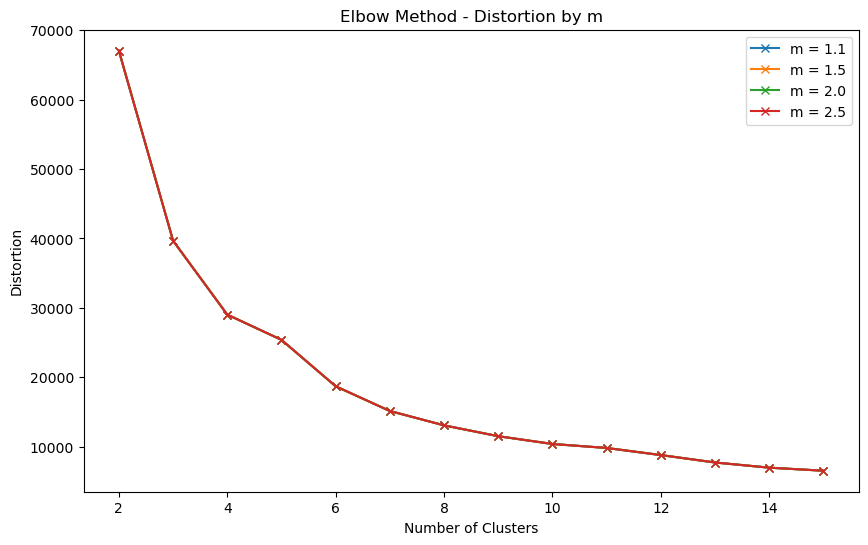

In [14]:
# Elbow Method
plt.figure(figsize=(10, 6))
for m in m_values:
    m_distortions = [d[2] for d in distortions if d[0] == m]
    m_clusters = [d[1] for d in distortions if d[0] == m]
    plt.plot(m_clusters, m_distortions, label=f"m = {m}", marker='x')
plt.title("Elbow Method - Distortion by m")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.legend()
plt.show()

In [15]:
# Convert to NumPy arrays for easier filtering
silhouette_scores = np.array(silhouette_scores)
fuzzy_sil_scores = np.array(fuzzy_sil_scores)
pc_scores = np.array(pc_scores)
pe_scores = np.array(pe_scores)
dbi_scores = np.array(dbi_scores)

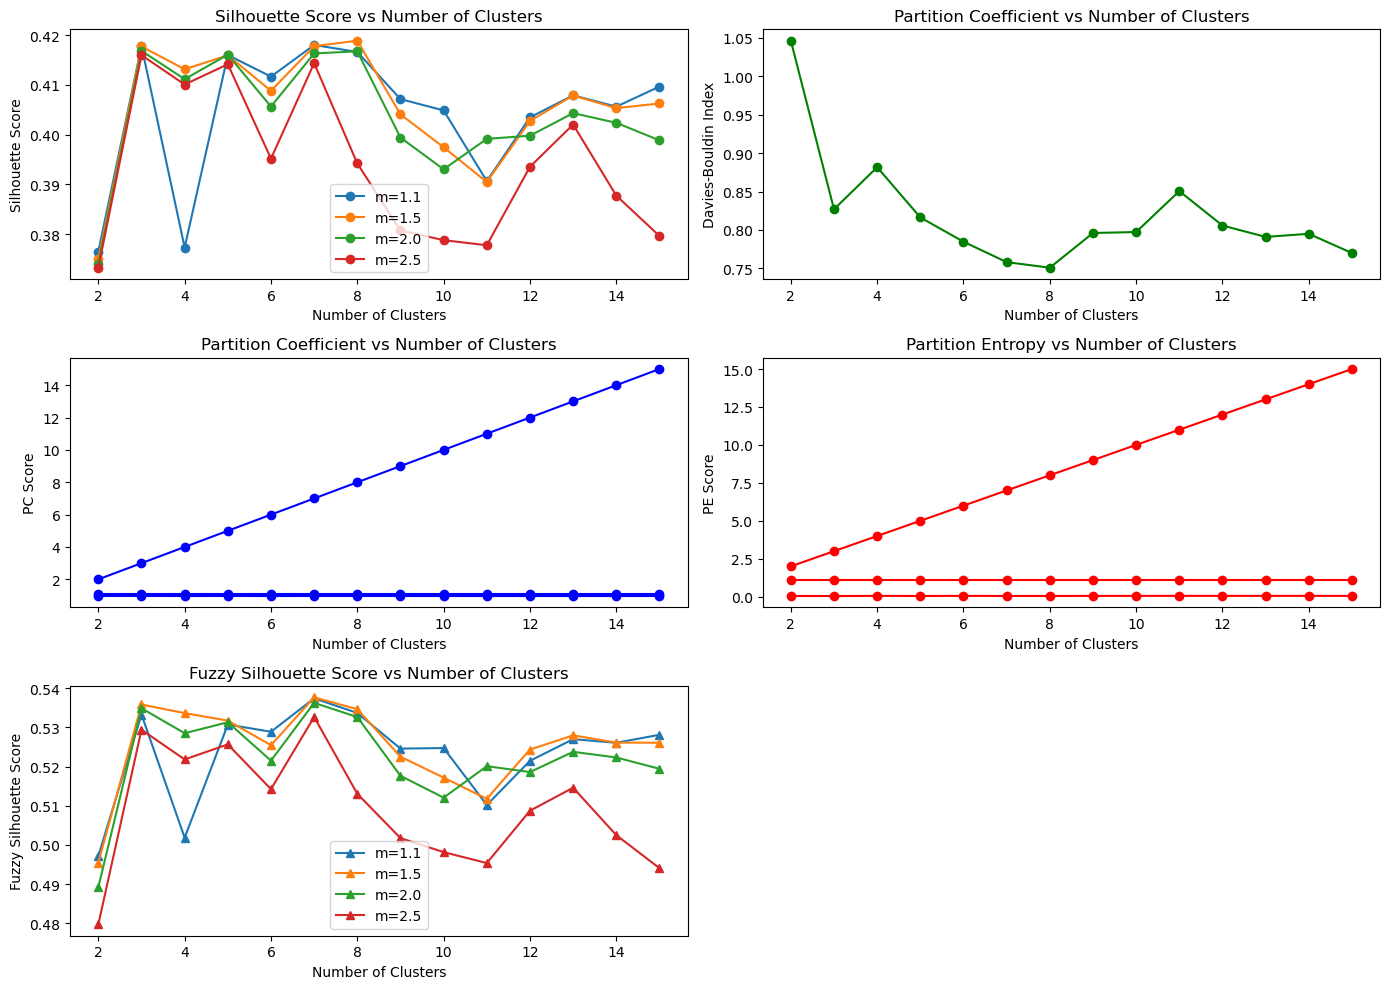

In [16]:
plt.figure(figsize=(14, 10))

# Subplot 1: Silhouette Score
plt.subplot(3, 2, 1)
for m in m_values:
    filtered = silhouette_scores[silhouette_scores[:, 0] == m]
    plt.plot(filtered[:, 1], filtered[:, 2], marker='o', label=f"m={m}")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()

# Subplot 2: Davies-Bouldin Index
plt.subplot(3, 2, 2)
plt.plot(cluster_range, dbi_scores[:len(cluster_range)], marker='o', color='green')
plt.title('Partition Coefficient vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

# Subplot 3: Partition Coefficient
plt.subplot(3, 2, 3)
plt.plot(cluster_range, pc_scores[:len(cluster_range)], marker='o', color='blue')
plt.title('Partition Coefficient vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('PC Score')

# Subplot 4: Partition Entropy
plt.subplot(3, 2, 4)
plt.plot(cluster_range, pe_scores[:len(cluster_range)], marker='o', color='red')
plt.title('Partition Entropy vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('PE Score')

# Subplot 5: Fuzzy Silhouette Score
plt.subplot(3, 2, 5)
for m in m_values:
    filtered = fuzzy_sil_scores[fuzzy_sil_scores[:, 0] == m]
    plt.plot(filtered[:, 1], filtered[:, 2], marker='^', label=f"m={m}")
plt.title("Fuzzy Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Fuzzy Silhouette Score")
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Save the scores into one data frame for a better evaluation
silhouette_df = pd.DataFrame(silhouette_scores, columns=["m", "n_clusters", "silhouette_score"])
fuzzy_sil_df = pd.DataFrame(fuzzy_sil_scores, columns=["m", "n_clusters", "fuzzy_silhouette_score"])
pc_df = pd.DataFrame(pc_scores, columns=["m", "n_clusters", "partition_coefficient"])
pe_df = pd.DataFrame(pe_scores, columns=["m", "n_clusters", "partition_entropy"])

# Merge all DataFrames into one final table
all_scores_df = silhouette_df.merge(pc_df, on=["m", "n_clusters"]) \
                             .merge(pe_df, on=["m", "n_clusters"]) \
                             .merge(fuzzy_sil_df, on=["m", "n_clusters"])

all_scores_df.head()

m  n_clusters  silhouette_score  partition_coefficient  \
0  1.1         2.0          0.376460               0.970275   
1  1.1         3.0          0.417830               0.973746   
2  1.1         4.0          0.377280               0.967935   
3  1.1         5.0          0.416016               0.971253   
4  1.1         6.0          0.411682               0.967703   

   partition_entropy  fuzzy_silhouette_score  
0           0.048839                0.497171  
1           0.043505                0.533277  
2           0.054078                0.501837  
3           0.048370                0.530721  
4           0.053828                0.528874

In [18]:
# Round metrics for neatness
all_scores_df['silhouette_score'] = all_scores_df['silhouette_score'].round(4)
all_scores_df['partition_coefficient'] = all_scores_df['partition_coefficient'].round(4)
all_scores_df['partition_entropy'] = all_scores_df['partition_entropy'].round(4)
all_scores_df['fuzzy_silhouette_score'] = all_scores_df['fuzzy_silhouette_score'].round(4)

# Top 3 Silhouette Scores
top_silhouette = all_scores_df.nlargest(3, 'silhouette_score')
print("Top Silhouette Scores:")
print(top_silhouette[['m', 'n_clusters', 'silhouette_score']], end="\n\n")

# Top 3 Partition Coefficient
top_pc = all_scores_df.nlargest(3, 'partition_coefficient')
print("Top Partition Coefficient (PC):")
print(top_pc[['m', 'n_clusters', 'partition_coefficient']], end="\n\n")

# Lowest 3 Partition Entropy
top_pe = all_scores_df.nsmallest(3, 'partition_entropy')
print("Lowest Partition Entropy (PE):")
print(top_pe[['m', 'n_clusters', 'partition_entropy']], end="\n\n")

# Top 3 Fuzzy Silhouette Scores
top_fuzzy_silhouette = all_scores_df.nlargest(3, 'fuzzy_silhouette_score')
print("Top Fuzzy Silhouette Scores:")
print(top_fuzzy_silhouette[['m', 'n_clusters', 'fuzzy_silhouette_score']], end="\n\n")

Top Silhouette Scores:
      m  n_clusters  silhouette_score
20  1.5         8.0            0.4189
5   1.1         7.0            0.4180
1   1.1         3.0            0.4178

Top Partition Coefficient (PC):
     m  n_clusters  partition_coefficient
1  1.1         3.0                 0.9737
3  1.1         5.0                 0.9713
5  1.1         7.0                 0.9709

Lowest Partition Entropy (PE):
     m  n_clusters  partition_entropy
1  1.1         3.0             0.0435
3  1.1         5.0             0.0484
0  1.1         2.0             0.0488

Top Fuzzy Silhouette Scores:
      m  n_clusters  fuzzy_silhouette_score
19  1.5         7.0                  0.5377
5   1.1         7.0                  0.5374
33  2.0         7.0                  0.5362



In [19]:
all_scores_df.corr(method='kendall')

m  n_clusters  silhouette_score  \
m                       1.000000    0.000000         -0.231474   
n_clusters              0.000000    1.000000         -0.149166   
silhouette_score       -0.231474   -0.149166          1.000000   
partition_coefficient  -0.843201   -0.227206          0.273999   
partition_entropy       0.806986    0.268463         -0.268618   
fuzzy_silhouette_score -0.282830   -0.123079          0.876873   

                        partition_coefficient  partition_entropy  \
m                                   -0.843201           0.806986   
n_clusters                          -0.227206           0.268463   
silhouette_score                     0.273999          -0.268618   
partition_coefficient                1.000000          -0.953866   
partition_entropy                   -0.953866           1.000000   
fuzzy_silhouette_score               0.310446          -0.299838   

                        fuzzy_silhouette_score  
m                                    -0.282830  
n_clusters                           -0.123079  
silhouette_score                      0.876873  
partition_coefficient                 0.310446  
partition_entropy                    -0.299838  
fuzzy_silhouette_score                1.000000

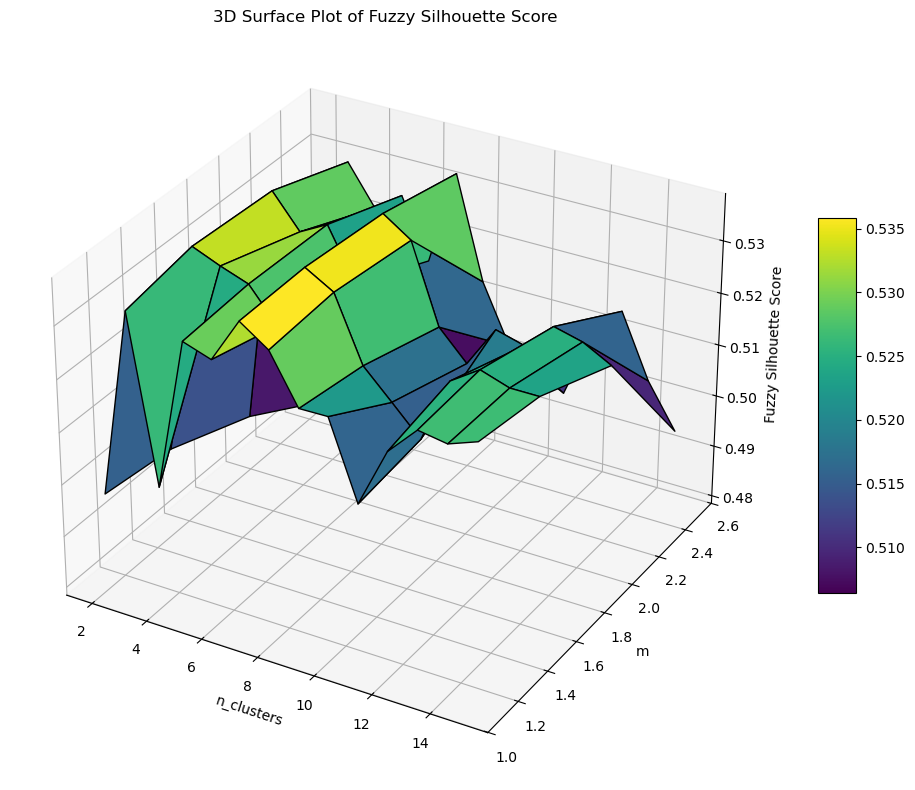

In [20]:
# Pivot the table to get m as rows, n_clusters as columns, fuzzy_silhouette_score as values
pivot_table = all_scores_df.pivot_table(index='m', columns='n_clusters', values='fuzzy_silhouette_score')

# Create a meshgrid for m and n_clusters
m_vals = pivot_table.index.values
n_vals = pivot_table.columns.values
M, N = np.meshgrid(n_vals, m_vals)
Z = pivot_table.values

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M, N, Z, cmap='viridis', edgecolor='k')
ax.set_xlabel('n_clusters')
ax.set_ylabel('m')
ax.set_zlabel('Fuzzy Silhouette Score')
ax.set_title('3D Surface Plot of Fuzzy Silhouette Score')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()

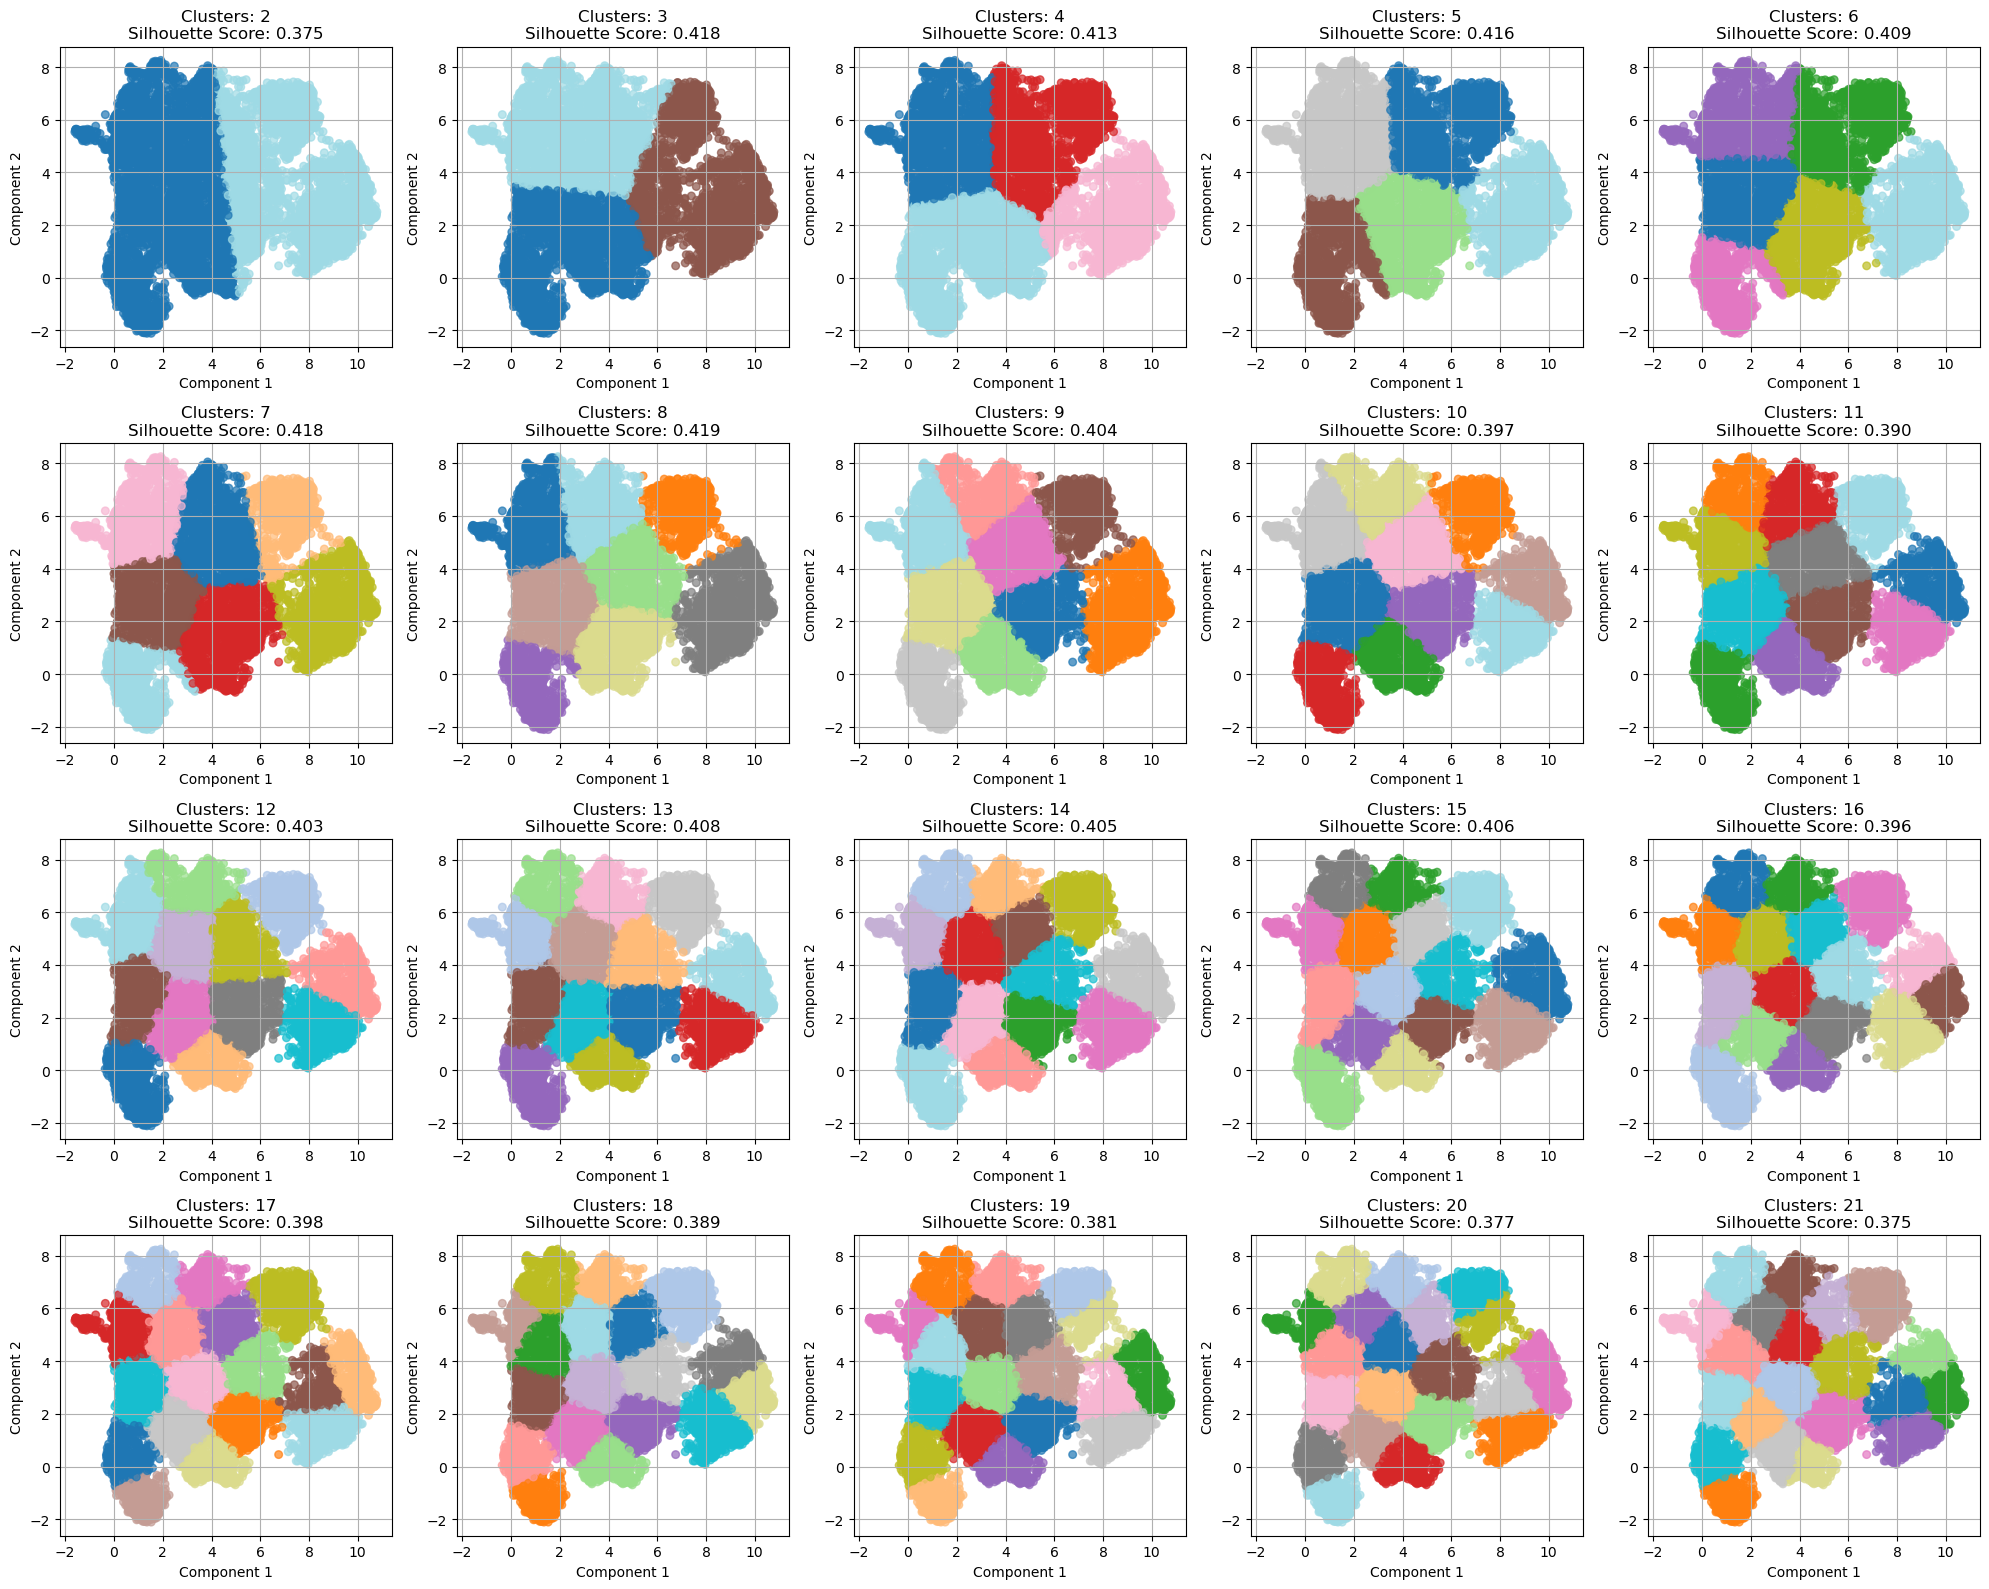

In [21]:
# Lastly, we fit the model with the best attribute value
m = 1.5
MAX_ITER = 1000
epsilon = 0.001

# Range of cluster numbers (from 2 to 21)
cluster_range = range(2, 22)

# Plot settings
n_cols = 5
n_rows = int(np.ceil(len(cluster_range) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axs = axs.flatten()

for i, k in enumerate(cluster_range):
    fcm = FCM(n_clusters=k, max_iter=MAX_ITER, m=m, error=epsilon, random_state=42)
    fcm.fit(X)
    labels = fcm.predict(X)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X, labels)
    
    # Plot the clusters
    ax = axs[i]
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                         c=labels, cmap='tab20', s=30, alpha=0.7)
    ax.set_title(f"Clusters: {k}\nSilhouette Score: {silhouette_avg:.3f}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

# Remove extra axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


Fit final model with best cluster number

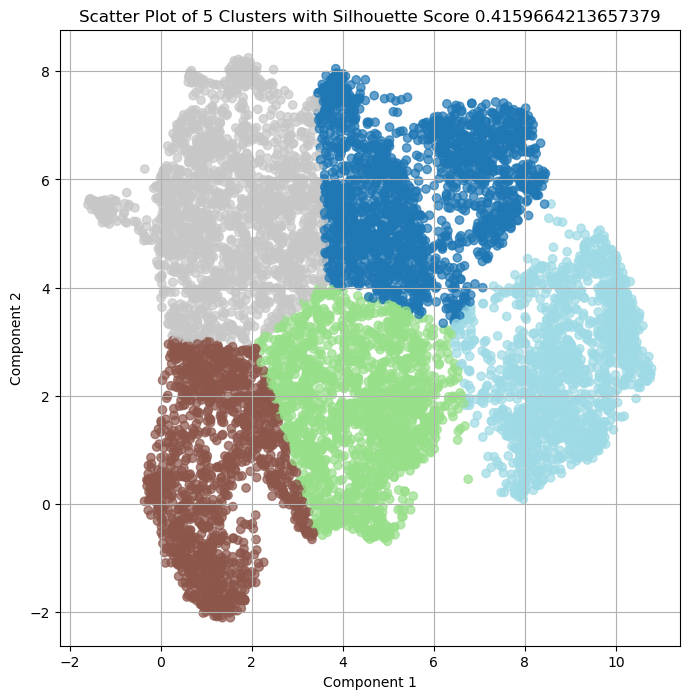

In [22]:
# Lastly, we fit the model with the best attribute value
optimal_clusters = 5
m = 1.5
MAX_ITER = 1000
epsilon = 0.001

fcm = FCM(n_clusters=optimal_clusters, max_iter=MAX_ITER, m=m, error=epsilon, random_state=42)
fcm.fit(X)
labels = fcm.predict(X)
silhouette_avg = silhouette_score(X, labels)
df['cluster'] = labels

# Plot the scatter graph
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20', alpha=0.7)
plt.title(f"Scatter Plot of {optimal_clusters} Clusters with Silhouette Score {silhouette_avg}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [23]:
membership = fcm.soft_predict(X) 
crisp_labels = np.argmax(membership, axis=1)
sil_score = silhouette_score(X, crisp_labels)

Find the common words among the clusters

In [24]:
# Function to clean and tokenize text
def tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    return tokens

all_words = []
extreme_frequent_words = []

for cluster_id in range(5):
    cluster_texts = df[df['cluster'] == cluster_id]['article'].tolist()
    cluster_tokens = []
    
    for text in cluster_texts:
        cluster_tokens.extend(tokenize(text))
    
    all_words.extend(cluster_tokens)

word_counts = Counter(all_words)
common_words = word_counts.most_common(100) 

for i, (word, freq) in enumerate(common_words, 1):
    print(f"{i:2}. {word:15} — {freq}")
    if freq > 2000:
        extreme_frequent_words.append(word)

print("\n Extreme Frequent Word > ")

for i, word in enumerate(extreme_frequent_words, 1):
    print(f"{i:2}. {word:15} — {freq}")


 1. say             — 53776
 2. climate         — 26127
 3. would           — 15663
 4. new             — 15089
 5. government      — 14465
 6. people          — 13680
 7. make            — 13308
 8. use             — 13218
 9. change          — 13028
10. year            — 12868
11. water           — 12159
12. also            — 11980
13. energy          — 11274
14. need            — 10950
15. one             — 10833
16. uk              — 10646
17. could           — 10269
18. emissions       — 10201
19. world           — 10091
20. us              — 10018
21. australia       — 9752
22. take            — 9444
23. time            — 9227
24. include         — 8999
25. years           — 8766
26. plan            — 8658
27. company         — 8533
28. get             — 8443
29. see             — 8264
30. find            — 8235
31. report          — 8070
32. gas             — 8008
33. go              — 7958
34. work            — 7648
35. last            — 7598
36. carbon          — 7578
37. glob

In [25]:
# Find rare words
rare_words = [word for word, freq in word_counts.items() if freq <= 30]

for i, word in enumerate(rare_words[:100], 1): 
    print(f"{i:2}. {word:15} — {word_counts[word]}")


 1. rightwingers    — 9
 2. pinchbeck       — 7
 3. wakefieldread   — 2
 4. morehouseholds  — 2
 5. embroil         — 12
 6. backbenches     — 10
 7. bim             — 3
 8. afolami         — 1
 9. hitchin         — 1
10. harpenden       — 2
11. shownet         — 1
12. grubb           — 4
13. constraint      — 15
14. oldus           — 21
15. forswear        — 2
16. romain          — 4
17. ioualalen       — 1
18. atrociously     — 1
19. unjust          — 29
20. willingly       — 8
21. wreckers        — 6
22. forego          — 9
23. elicit          — 7
24. promotiontessa  — 1
25. outsized        — 16
26. habitable       — 27
27. obscene         — 15
28. disarray        — 15
29. itlucy          — 2
30. sherriff        — 3
31. lacklustre      — 6
32. clown           — 7
33. wrestle         — 28
34. oust            — 25
35. carnage         — 11
36. videobut        — 8
37. beleaguer       — 16
38. blister         — 29
39. sigh            — 22
40. faux            — 13
41. pas             — 4


### Clean the Common Words and retrain the model

In [26]:
df = pd.read_csv("data/model_data.csv")

rare_words_set = set(rare_words)

df["article"] = df["article"].apply(
    lambda x: ' '.join([
        word for word in x.split()
        if word.lower() not in extreme_frequent_words and word.lower() not in rare_words_set
    ])
)


In [27]:
# Use pretrained model BERT to transform the words
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

X_bert = get_bert_embeddings(df['article'].tolist())
X_scaled = StandardScaler().fit_transform(X_bert)

# Use PCA to reduce dimension into 50
pca = TruncatedSVD(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Use UMAP to reduce the dimension into 2 for visualization purpose
reducer = UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='cosine', random_state=42)
X = reducer.fit_transform(X_pca)

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Train again with All Clusters Range

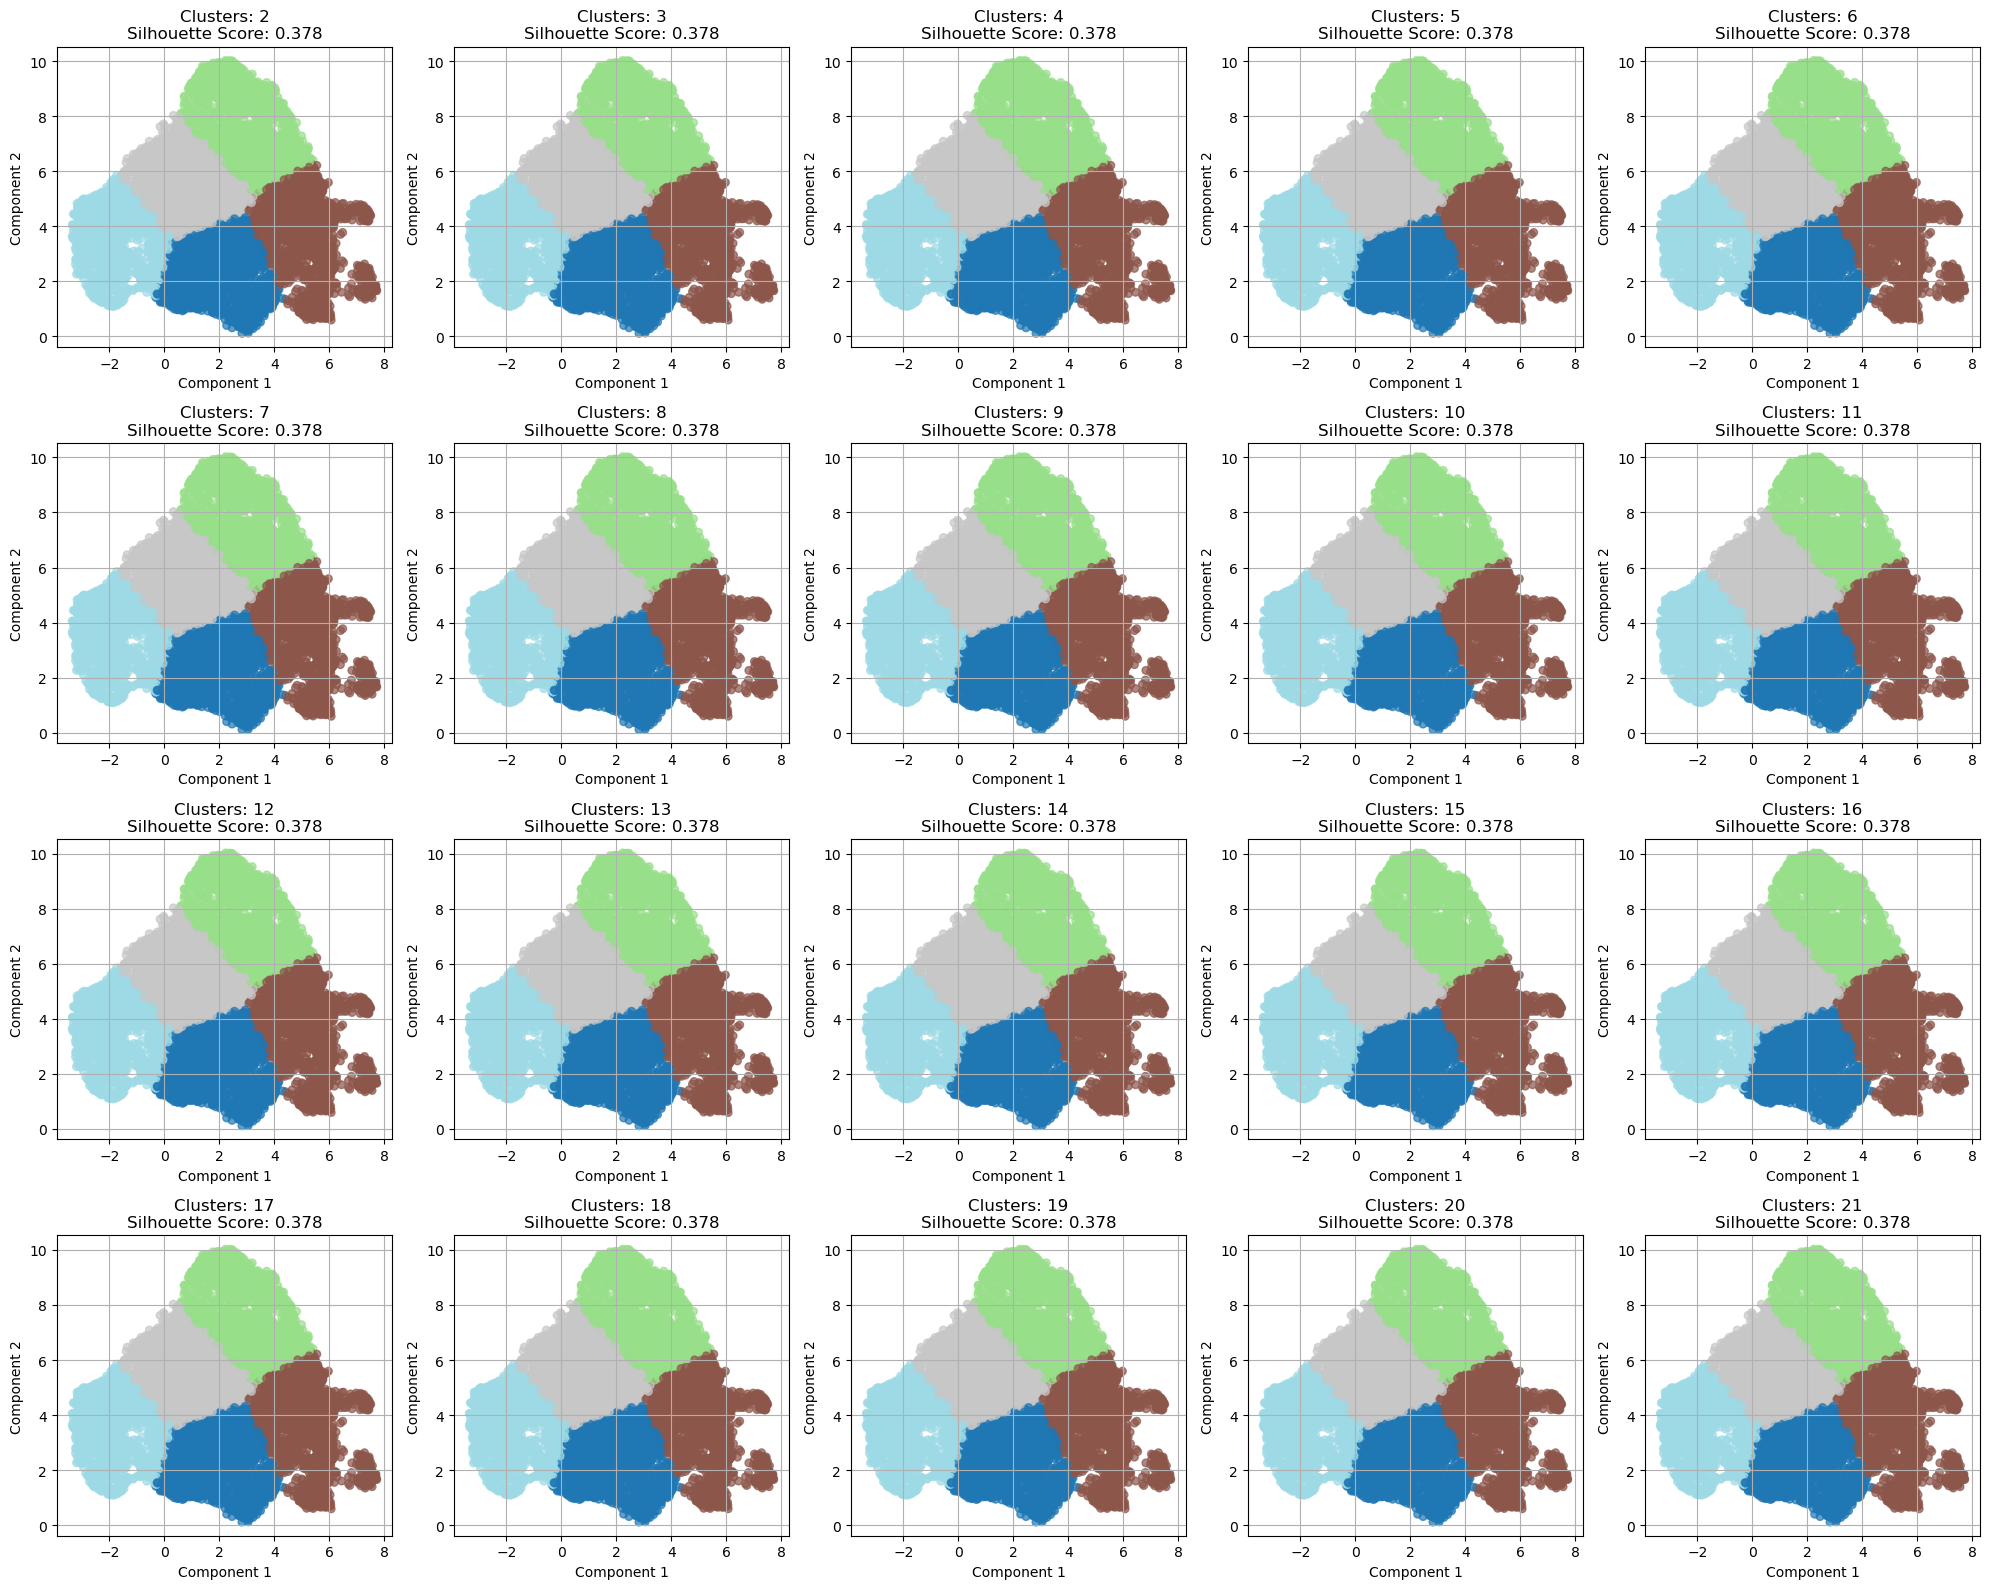

In [28]:
# Lastly, we fit the model with the best attribute value
m = 1.5
MAX_ITER = 1000
epsilon = 0.001

# Range of cluster numbers (from 2 to 21)
cluster_range = range(2, 22)

# Plot settings
n_cols = 5
n_rows = int(np.ceil(len(cluster_range) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axs = axs.flatten()

for i, k in enumerate(cluster_range):
    fcm = FCM(n_clusters=optimal_clusters, max_iter=MAX_ITER, m=m, error=epsilon, random_state=42)
    fcm.fit(X)
    labels = fcm.predict(X)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X, labels)
    
    # Plot the clusters
    ax = axs[i]
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                         c=labels, cmap='tab20', s=30, alpha=0.7)
    ax.set_title(f"Clusters: {k}\nSilhouette Score: {silhouette_avg:.3f}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

# Remove extra axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Final Model

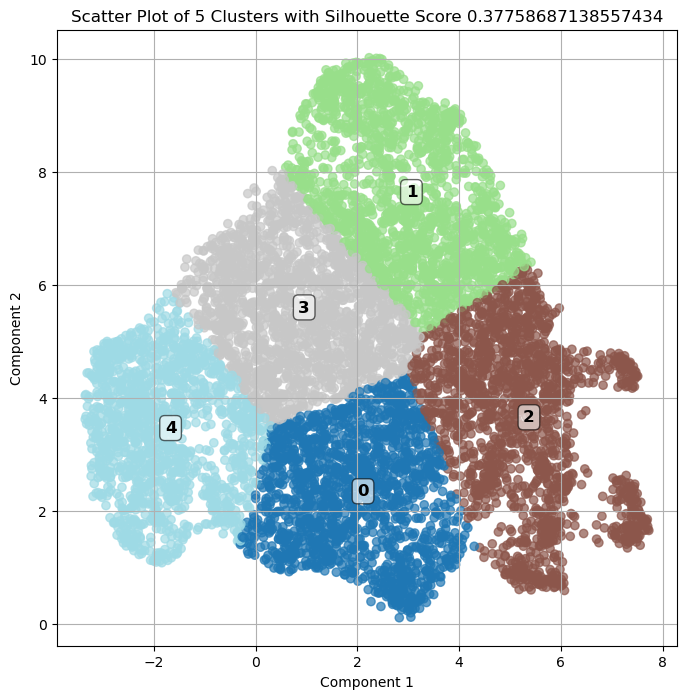


Number of data points per cluster > 
Cluster 0: 1659 points
Cluster 1: 1765 points
Cluster 2: 1717 points
Cluster 3: 1664 points
Cluster 4: 1382 points


In [29]:
# Lastly, we fit the model with the best attribute value
optimal_clusters = 5
m = 1.5
MAX_ITER = 1000
epsilon = 0.001

fcm = FCM(n_clusters=optimal_clusters, max_iter=MAX_ITER, m=m, error=epsilon, random_state=42)
fcm.fit(X)
labels = fcm.predict(X)
silhouette_avg = silhouette_score(X, labels)
df['cluster'] = labels

# Plot the scatter graph
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:,1], c=labels, cmap='tab20', alpha=0.7)
plt.title(f"Scatter Plot of {optimal_clusters} Clusters with Silhouette Score {silhouette_avg}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
for cluster_id in np.unique(labels):
    cluster_points = X[labels == cluster_id]
    center = cluster_points.mean(axis=0)
    plt.text(center[0], center[1], str(cluster_id), 
             fontsize=12, fontweight='bold', color='black',
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.3'))
plt.show()

cluster_counts = pd.Series(labels).value_counts().sort_index()
print("\nNumber of data points per cluster > ")
for i, count in cluster_counts.items():
    print(f"Cluster {i}: {count} points")

Find the membership cluster and its cluster

C:\Users\User\AppData\Local\Temp\ipykernel_24220\4099976072.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(fcm.n_clusters)), y=cluster_avg_membership, palette='Blues')


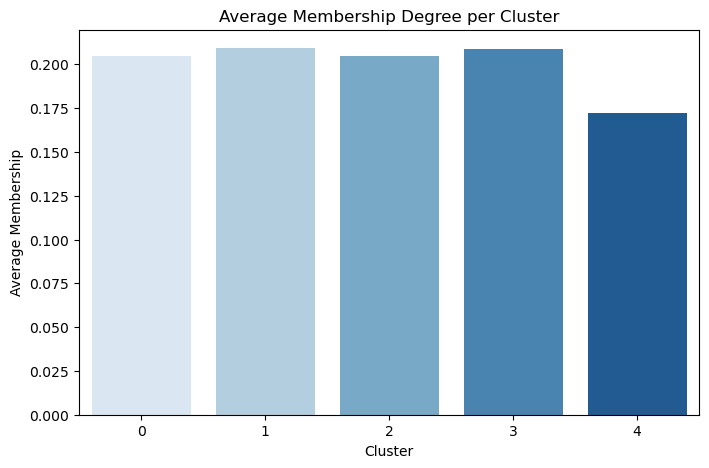

In [31]:
# Average membership per cluster
cluster_avg_membership = np.mean(fcm.u, axis=0)

# Plot as bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(fcm.n_clusters)), y=cluster_avg_membership, palette='Blues')
plt.title("Average Membership Degree per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Membership")
plt.show()

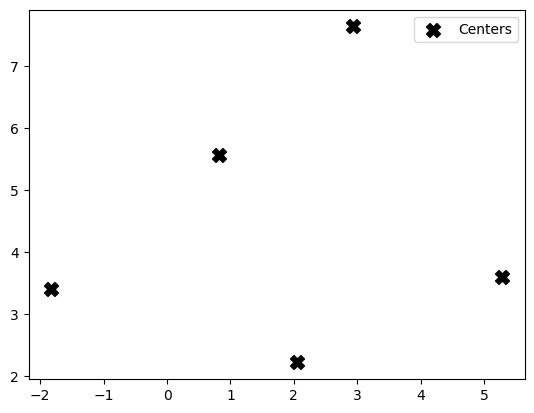

In [32]:
plt.scatter(fcm.centers[:, 0], fcm.centers[:, 1], 
            c='black', s=100, marker='X', label='Centers')
plt.legend()

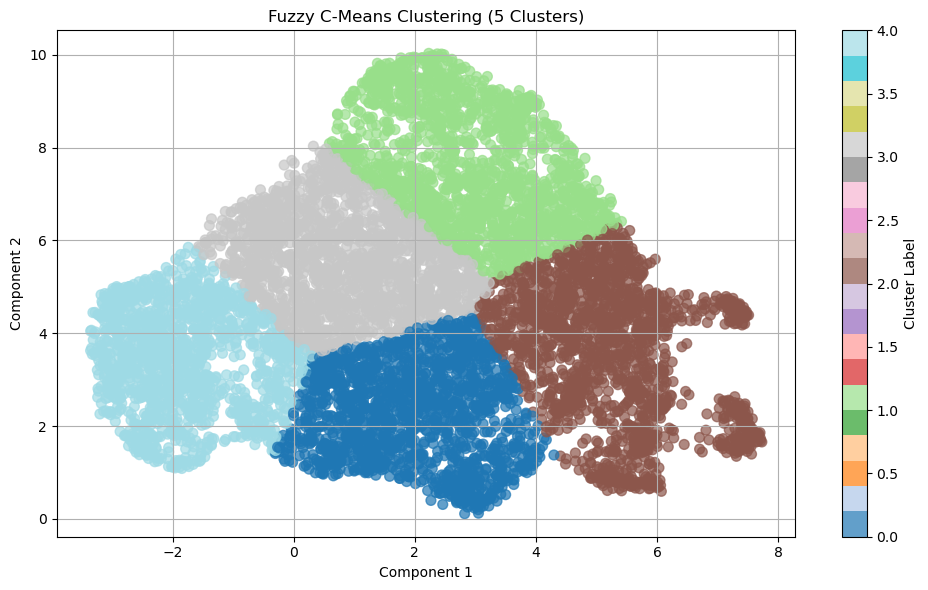

In [33]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], 
                      c=labels, cmap='tab20', s=50, alpha=0.7)

plt.title("Fuzzy C-Means Clustering ({} Clusters)".format(optimal_clusters))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
threshold = 0.8
for cluster_id in range(optimal_clusters):
    high_membership_points = df[fcm.u[:, cluster_id] > threshold]
    print(f"\nCluster {cluster_id} - High Membership Samples: {len(high_membership_points)}")


Cluster 0 - High Membership Samples: 1184

Cluster 1 - High Membership Samples: 1270

Cluster 2 - High Membership Samples: 1277

Cluster 3 - High Membership Samples: 997

Cluster 4 - High Membership Samples: 1132


In [36]:
membership = fcm.soft_predict(X_umap)  # Shape: (n_samples, n_clusters)
crisp_labels = np.argmax(membership, axis=1)
sil_score = silhouette_score(X_umap, crisp_labels)
print(sil_score)

0.2688306


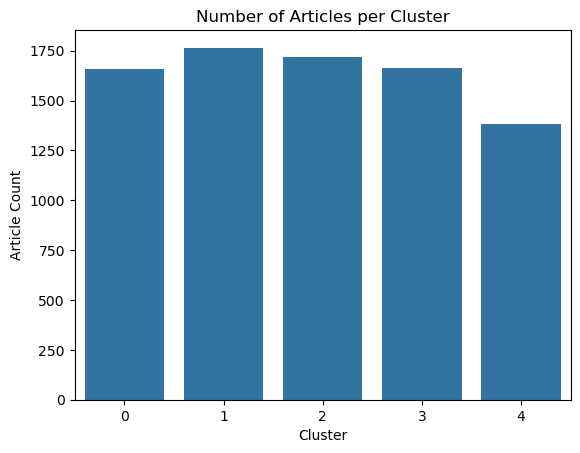

In [37]:
sns.countplot(x='cluster', data=df)
plt.title("Number of Articles per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Article Count")
plt.show()

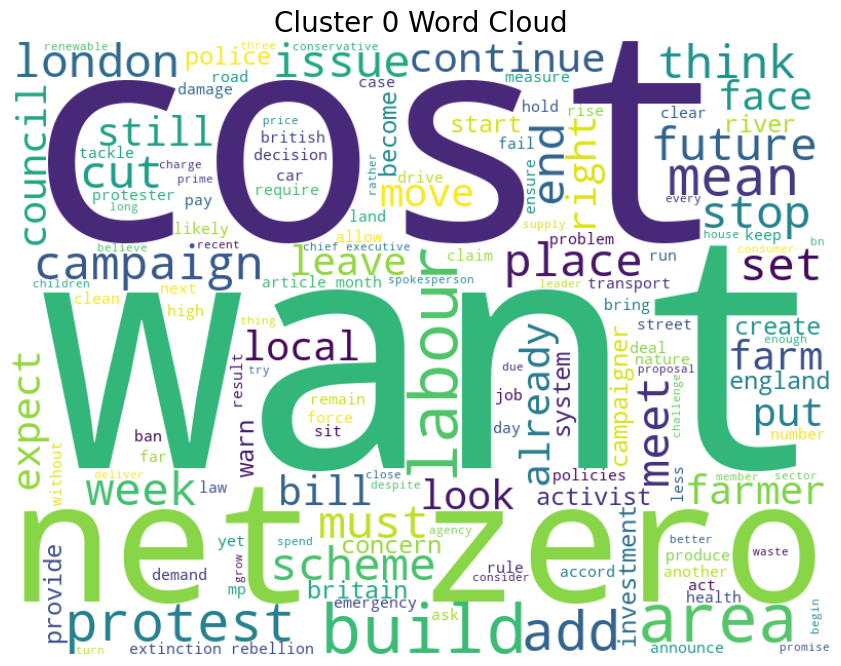

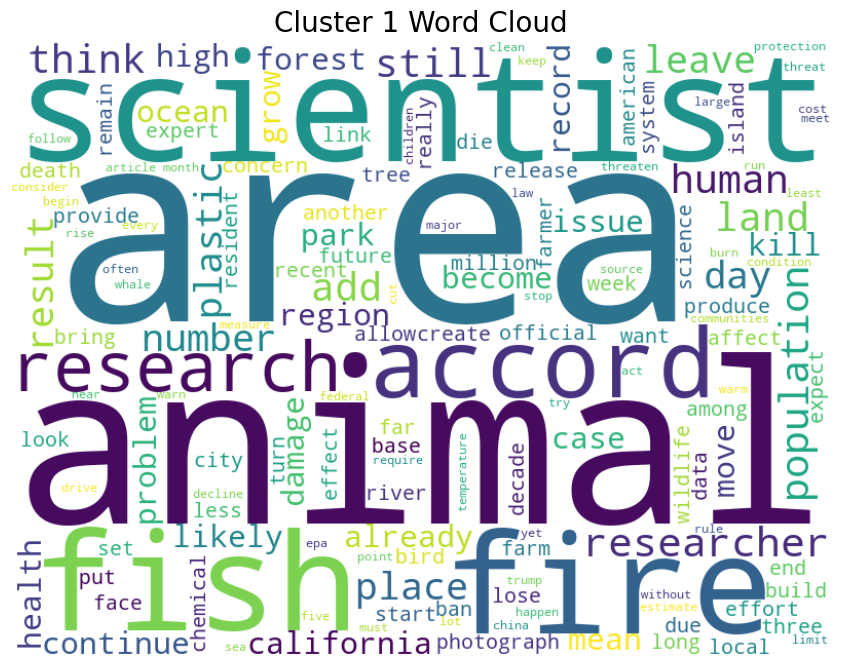

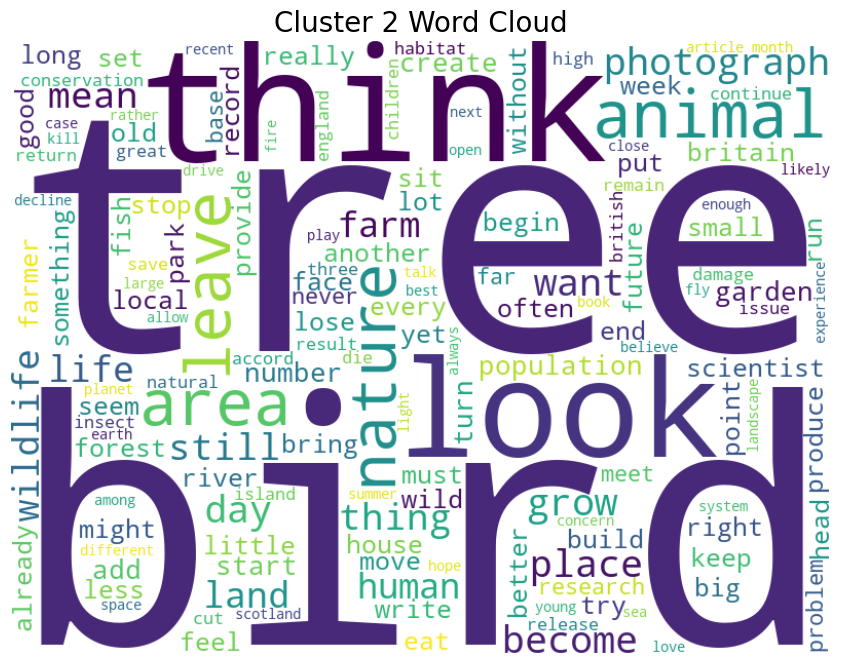

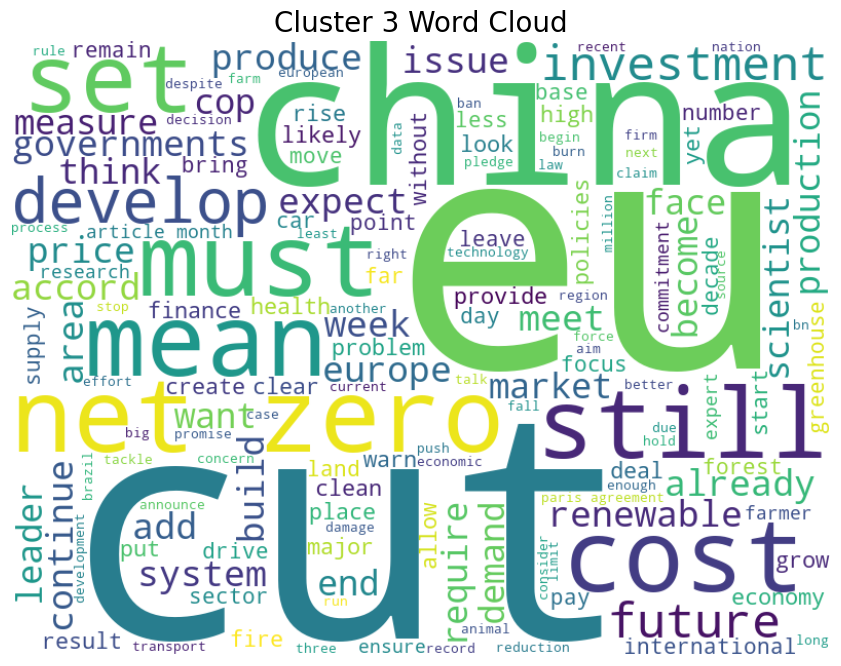

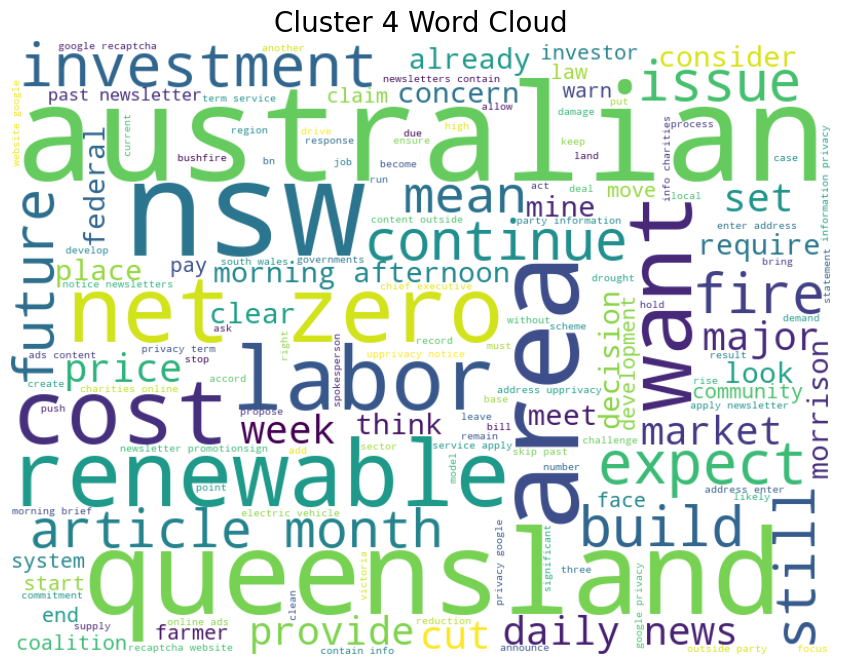

In [38]:
for i in range(optimal_clusters):
    texts = df[df['cluster'] == i]['article']
    combined_text = " ".join(texts)

    # Increase image size and word count
    wordcloud = WordCloud(
        background_color='white',
        max_words=150,          
        width=800,              
        height=600,            
        colormap='viridis'     
    ).generate(combined_text)

    plt.figure(figsize=(16, 8))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {i} Word Cloud", fontsize=20)
    plt.show()

In [41]:

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation and make lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    return words

for cluster_num in sorted(df['cluster'].unique()):
    cluster_texts = df[df['cluster'] == cluster_num]["article"]
    
    all_words = []
    for text in cluster_texts:
        all_words.extend(preprocess_text(text))
    
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(50)
    
    print(f"\nCluster {cluster_num} - Top 50 words:")
    for word, count in top_words:
        print(f"{word}: {count}")


Cluster 0 - Top 50 words:
london: 1542
party: 1514
plastic: 1385
protest: 1336
labour: 1259
local: 1201
cost: 1189
england: 1169
zero: 1145
want: 1106
week: 1079
farm: 1073
meet: 1055
address: 1033
right: 1031
stop: 1031
waste: 1030
scheme: 996
build: 992
health: 983
future: 981
campaign: 975
bill: 970
business: 968
cut: 961
bn: 961
issue: 957
set: 946
ban: 946
police: 944
net: 937
term: 932
day: 923
farmers: 902
months: 893
must: 878
high: 877
put: 865
place: 861
end: 856
add: 853
service: 849
mean: 842
britain: 829
since: 829
sewage: 818
pay: 814
think: 807
transport: 802
next: 795

Cluster 1 - Top 50 words:
fish: 1610
research: 1544
health: 1493
fire: 1473
scientists: 1385
accord: 1268
plastic: 1254
university: 1245
sea: 1220
california: 1171
land: 1144
areas: 1107
animals: 1098
whale: 1062
since: 1040
park: 1037
rise: 1018
human: 1008
number: 1008
photograph: 997
high: 993
researchers: 990
forest: 975
trump: 962
record: 959
right: 957
marine: 948
long: 938
become: 924
still: 897
g

In [42]:
cluster_labels = {
    0: "UK Environmental Politics & Protests",
    1: "Scientific Research & Marine Conservation",
    2: "Nature & Wildlife Conservation",
    3: "Global Climate Policy & Emissions",
    4: "Australian News & Energy Market"
}

# Replace cluster numbers with descriptive labels
df['label'] = df['cluster'].map(cluster_labels)

# Check the distribution
print(df['label'].value_counts())

label
Scientific Research & Marine Conservation    1765
Nature & Wildlife Conservation               1717
Global Climate Policy & Emissions            1664
UK Environmental Politics & Protests         1659
Australian News & Energy Market              1382
Name: count, dtype: int64


In [44]:
df.to_csv("data/clustered_data.csv", index=False)

In [ ]:
# Save the model
with open('model/model.pkl', 'wb') as file:
    pickle.dump(fcm, file)